In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from rapidfuzz import process, fuzz

In [2]:
MODEL_PATH = "../data/clean/resnet50_food101_final.keras"
LABEL_MAP_PATH = "../data/clean/label_map.json"
USDA_PATH = "../data/raw/usda_food_data.csv"
IMG_DIR = "../data/raw/food-101/images"

# Load model
model = load_model(MODEL_PATH)
print("Model Loaded!")

# Load label encoder mapping
with open(LABEL_MAP_PATH, "r") as f:
    label_map = json.load(f)

idx_to_label = {v: k for k, v in label_map.items()}
num_classes = len(idx_to_label)
print("Labels Loaded:", num_classes)

Model Loaded!
Labels Loaded: 101


In [3]:
usda_df = pd.read_csv(USDA_PATH)

def find_nutrition(food_name):
    food_name = food_name.lower().strip()

    # 1. Try exact match on the 'query' column
    exact = usda_df[usda_df["query"].str.lower() == food_name]
    if not exact.empty:
        return exact.iloc[0]

    # 2. Otherwise fuzzy match using query column (best match)
    match = process.extractOne(
        food_name.replace("_", " "),
        usda_df["query"].astype(str),
        scorer=fuzz.token_sort_ratio
    )

    if match and match[1] > 70:
        matched_query = match[0]
        row = usda_df[usda_df["query"] == matched_query]
        if not row.empty:
            return row.iloc[0]

    return None

In [4]:
def predict_image(img_path):

    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis("off")
    
    img_arr = image.img_to_array(img)
    img_arr = preprocess_input(img_arr)  # for ResNet50
    img_arr = np.expand_dims(img_arr, axis=0)

    # Prediction
    preds = model.predict(img_arr)
    top5_idx = preds[0].argsort()[-5:][::-1]

    print("\n--- Predictions ---")
    for rank, idx in enumerate(top5_idx, start=1):
        label = idx_to_label[idx]
        score = preds[0][idx]
        print(f"{rank}. {label}  ({score:.4f})")

    # Nutrition for Top-1
    top1_label = idx_to_label[top5_idx[0]]
    nutri = find_nutrition(top1_label)

    if nutri is not None:
        print("\n--- Nutrition Info ---")
        print(nutri[["description", "calories", "protein", "fat", "carbohydrates"]])
    else:
        print("\nNo nutrition match found.")

Testing image: ../data/raw/food-101/images/foie_gras/15207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

--- Predictions ---
1. foie_gras  (0.5083)
2. tuna_tartare  (0.1933)
3. beef_tartare  (0.0579)
4. scallops  (0.0478)
5. filet_mignon  (0.0426)

--- Nutrition Info ---
description      LIVER PATE
calories              267.0
protein                13.3
fat                    21.7
carbohydrates          6.67
Name: 39, dtype: object


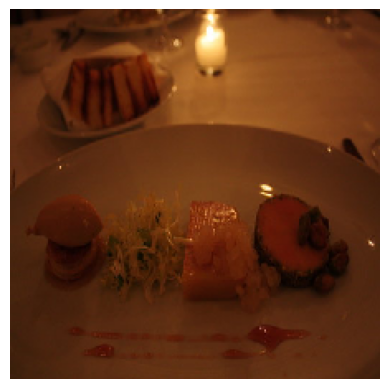

In [10]:
import random

test_df = pd.read_csv("../data/clean/test_cleaned.csv")

random_row = test_df.sample(1).iloc[0]
img_name = random_row["image_name"]
img_path = "../data/raw/food-101/images/prime_rib/1208845.jpg"

print("Testing image:", img_path)
predict_image(img_path)

In [6]:
from tqdm import tqdm

SAMPLE = 1000
subset = test_df.sample(SAMPLE)

top1_correct = 0
top5_correct = 0

for _, row in tqdm(subset.iterrows(), total=SAMPLE):
    img_path = os.path.join(IMG_DIR, row["image_name"] + ".jpg")
    true_label = row["label"]

    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    img_arr = preprocess_input(img_arr)
    img_arr = np.expand_dims(img_arr, axis=0)

    preds = model.predict(img_arr)
    top5_idx = preds[0].argsort()[-5:][::-1]
    top5_labels = [idx_to_label[i] for i in top5_idx]

    if top5_labels[0] == true_label:
        top1_correct += 1
    if true_label in top5_labels:
        top5_correct += 1

print("\nSubset size:", SAMPLE)
print("Top-1 Accuracy:", top1_correct / SAMPLE)
print("Top-5 Accuracy:", top5_correct / SAMPLE)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  0%|                                          | 2/1000 [00:00<01:22, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  0%|▏                                         | 4/1000 [00:00<01:21, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  1%|▎                                         | 6/1000 [00:00<01:19, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  1%|▎                                         | 8/1000 [00:00<01:18, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  1%|▍                                        | 10/1000 [00:00<01:18, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  1%|▍                                        | 12/1000 [00:00<01:17, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  1%|▌                                        | 14/1000 [00:01<01:18, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  2%|▋                                        | 16/1000 [00:01<01:18, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  2%|▋                                        | 18/1000 [00:01<01:17, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  2%|▊                                        | 20/1000 [00:01<01:17, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  2%|▉                                        | 22/1000 [00:01<01:17, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  2%|▉                                        | 24/1000 [00:01<01:16, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  3%|█                                        | 26/1000 [00:02<01:15, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  3%|█▏                                       | 28/1000 [00:02<01:14, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  3%|█▏                                       | 30/1000 [00:02<01:13, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  3%|█▎                                       | 32/1000 [00:02<01:13, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  3%|█▍                                       | 34/1000 [00:02<01:12, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|█▍                                       | 36/1000 [00:02<01:12, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|█▌                                       | 38/1000 [00:02<01:13, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|█▋                                       | 40/1000 [00:03<01:13, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  4%|█▋                                       | 42/1000 [00:03<01:12, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  4%|█▊                                       | 44/1000 [00:03<01:11, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  5%|█▉                                       | 46/1000 [00:03<01:11, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  5%|█▉                                       | 48/1000 [00:03<01:10, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  5%|██                                       | 50/1000 [00:03<01:10, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  5%|██▏                                      | 52/1000 [00:03<01:09, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  5%|██▏                                      | 54/1000 [00:04<01:09, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|██▎                                      | 56/1000 [00:04<01:09, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|██▍                                      | 58/1000 [00:04<01:08, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  6%|██▍                                      | 60/1000 [00:04<01:10, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  6%|██▌                                      | 62/1000 [00:04<01:10, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  6%|██▌                                      | 64/1000 [00:04<01:09, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  7%|██▋                                      | 66/1000 [00:05<01:09, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  7%|██▊                                      | 68/1000 [00:05<01:08, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  7%|██▊                                      | 70/1000 [00:05<01:08, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|██▉                                      | 72/1000 [00:05<01:08, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  7%|███                                      | 74/1000 [00:05<01:07, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|███                                      | 76/1000 [00:05<01:07, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|███▏                                     | 78/1000 [00:05<01:07, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  8%|███▎                                     | 80/1000 [00:06<01:08, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  8%|███▎                                     | 82/1000 [00:06<01:08, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|███▍                                     | 84/1000 [00:06<01:07, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  9%|███▌                                     | 86/1000 [00:06<01:07, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  9%|███▌                                     | 88/1000 [00:06<01:08, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  9%|███▋                                     | 90/1000 [00:06<01:08, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  9%|███▊                                     | 92/1000 [00:06<01:09, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  9%|███▊                                     | 94/1000 [00:07<01:08, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|███▉                                     | 96/1000 [00:07<01:08, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 10%|████                                     | 98/1000 [00:07<01:08, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|████                                    | 100/1000 [00:07<01:07, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|████                                    | 102/1000 [00:07<01:07, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 10%|████▏                                   | 104/1000 [00:07<01:07, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 11%|████▏                                   | 106/1000 [00:08<01:07, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 11%|████▎                                   | 108/1000 [00:08<01:07, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 11%|████▍                                   | 110/1000 [00:08<01:07, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 11%|████▍                                   | 112/1000 [00:08<01:07, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 11%|████▌                                   | 114/1000 [00:08<01:06, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 12%|████▋                                   | 116/1000 [00:08<01:06, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|████▋                                   | 118/1000 [00:08<01:06, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|████▊                                   | 120/1000 [00:09<01:06, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|████▉                                   | 122/1000 [00:09<01:05, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|████▉                                   | 124/1000 [00:09<01:06, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 13%|█████                                   | 126/1000 [00:09<01:06, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 13%|█████                                   | 128/1000 [00:09<01:06, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 13%|█████▏                                  | 130/1000 [00:09<01:05, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 13%|█████▎                                  | 132/1000 [00:09<01:05, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 13%|█████▎                                  | 134/1000 [00:10<01:05, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|█████▍                                  | 136/1000 [00:10<01:05, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|█████▌                                  | 138/1000 [00:10<01:05, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 14%|█████▌                                  | 140/1000 [00:10<01:05, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 14%|█████▋                                  | 142/1000 [00:10<01:04, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|█████▊                                  | 144/1000 [00:10<01:04, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 15%|█████▊                                  | 146/1000 [00:11<01:04, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 15%|█████▉                                  | 148/1000 [00:11<01:04, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 15%|██████                                  | 150/1000 [00:11<01:04, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 15%|██████                                  | 152/1000 [00:11<01:04, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 15%|██████▏                                 | 154/1000 [00:11<01:03, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|██████▏                                 | 156/1000 [00:11<01:03, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 16%|██████▎                                 | 158/1000 [00:11<01:02, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 16%|██████▍                                 | 160/1000 [00:12<01:02, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 16%|██████▍                                 | 162/1000 [00:12<01:02, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 16%|██████▌                                 | 164/1000 [00:12<01:02, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 17%|██████▋                                 | 166/1000 [00:12<01:01, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 17%|██████▋                                 | 168/1000 [00:12<01:01, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 17%|██████▊                                 | 170/1000 [00:12<01:01, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 17%|██████▉                                 | 172/1000 [00:12<01:01, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 17%|██████▉                                 | 174/1000 [00:13<01:01, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 18%|███████                                 | 176/1000 [00:13<01:01, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 18%|███████                                 | 178/1000 [00:13<01:01, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 18%|███████▏                                | 180/1000 [00:13<01:00, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 18%|███████▎                                | 182/1000 [00:13<01:00, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 18%|███████▎                                | 184/1000 [00:13<01:00, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 19%|███████▍                                | 186/1000 [00:14<01:00, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|███████▌                                | 188/1000 [00:14<01:00, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 19%|███████▌                                | 190/1000 [00:14<01:00, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|███████▋                                | 192/1000 [00:14<01:00, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 19%|███████▊                                | 194/1000 [00:14<01:00, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|███████▊                                | 196/1000 [00:14<00:59, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|███████▉                                | 198/1000 [00:14<00:59, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 20%|████████                                | 200/1000 [00:15<00:59, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|████████                                | 202/1000 [00:15<00:59, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|████████▏                               | 204/1000 [00:15<00:59, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 21%|████████▏                               | 206/1000 [00:15<00:59, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 21%|████████▎                               | 208/1000 [00:15<00:59, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 21%|████████▍                               | 210/1000 [00:15<00:58, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 21%|████████▍                               | 212/1000 [00:15<00:58, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 21%|████████▌                               | 214/1000 [00:16<00:58, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 22%|████████▋                               | 216/1000 [00:16<00:58, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 22%|████████▋                               | 218/1000 [00:16<00:58, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|████████▊                               | 220/1000 [00:16<00:58, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 22%|████████▉                               | 222/1000 [00:16<00:58, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 22%|████████▉                               | 224/1000 [00:16<00:58, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|█████████                               | 226/1000 [00:17<00:57, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|█████████                               | 228/1000 [00:17<00:57, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|█████████▏                              | 230/1000 [00:17<00:57, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|█████████▎                              | 232/1000 [00:17<00:57, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|█████████▎                              | 234/1000 [00:17<00:57, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|█████████▍                              | 236/1000 [00:17<00:57, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 24%|█████████▌                              | 238/1000 [00:17<00:56, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|█████████▌                              | 240/1000 [00:18<00:56, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 24%|█████████▋                              | 242/1000 [00:18<00:56, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 24%|█████████▊                              | 244/1000 [00:18<00:56, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 25%|█████████▊                              | 246/1000 [00:18<00:56, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 25%|█████████▉                              | 248/1000 [00:18<00:56, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 25%|██████████                              | 250/1000 [00:18<00:55, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██████████                              | 252/1000 [00:18<00:55, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██████████▏                             | 254/1000 [00:19<00:55, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 26%|██████████▏                             | 256/1000 [00:19<00:55, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 26%|██████████▎                             | 258/1000 [00:19<00:55, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 26%|██████████▍                             | 260/1000 [00:19<00:55, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 26%|██████████▍                             | 262/1000 [00:19<00:54, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 26%|██████████▌                             | 264/1000 [00:19<00:55, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██████████▋                             | 266/1000 [00:20<00:54, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██████████▋                             | 268/1000 [00:20<00:54, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██████████▊                             | 270/1000 [00:20<00:54, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 27%|██████████▉                             | 272/1000 [00:20<00:54, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██████████▉                             | 274/1000 [00:20<00:54, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 28%|███████████                             | 276/1000 [00:20<00:54, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 28%|███████████                             | 278/1000 [00:20<00:54, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 28%|███████████▏                            | 280/1000 [00:21<00:54, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 28%|███████████▎                            | 282/1000 [00:21<00:53, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 28%|███████████▎                            | 284/1000 [00:21<00:53, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 29%|███████████▍                            | 286/1000 [00:21<00:53, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 29%|███████████▌                            | 288/1000 [00:21<00:53, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 29%|███████████▌                            | 290/1000 [00:21<00:52, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 29%|███████████▋                            | 292/1000 [00:21<00:52, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 29%|███████████▊                            | 294/1000 [00:22<00:52, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|███████████▊                            | 296/1000 [00:22<00:52, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|███████████▉                            | 298/1000 [00:22<00:52, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|████████████                            | 300/1000 [00:22<00:52, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|████████████                            | 302/1000 [00:22<00:51, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|████████████▏                           | 304/1000 [00:22<00:51, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 31%|████████████▏                           | 306/1000 [00:22<00:52, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|████████████▎                           | 308/1000 [00:23<00:52, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 31%|████████████▍                           | 310/1000 [00:23<00:52, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 31%|████████████▍                           | 312/1000 [00:23<00:51, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|████████████▌                           | 314/1000 [00:23<00:51, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|████████████▋                           | 316/1000 [00:23<00:51, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|████████████▋                           | 318/1000 [00:23<00:51, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|████████████▊                           | 320/1000 [00:24<00:50, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|████████████▉                           | 322/1000 [00:24<00:50, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|████████████▉                           | 324/1000 [00:24<00:50, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 33%|█████████████                           | 326/1000 [00:24<00:50, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 33%|█████████████                           | 328/1000 [00:24<00:50, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 33%|█████████████▏                          | 330/1000 [00:24<00:50, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|█████████████▎                          | 332/1000 [00:24<00:50, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 33%|█████████████▎                          | 334/1000 [00:25<00:49, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|█████████████▍                          | 336/1000 [00:25<00:49, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 34%|█████████████▌                          | 338/1000 [00:25<00:49, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 34%|█████████████▌                          | 340/1000 [00:25<00:49, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|█████████████▋                          | 342/1000 [00:25<00:48, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|█████████████▊                          | 344/1000 [00:25<00:48, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 35%|█████████████▊                          | 346/1000 [00:25<00:48, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 35%|█████████████▉                          | 348/1000 [00:26<00:48, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|██████████████                          | 350/1000 [00:26<00:48, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|██████████████                          | 352/1000 [00:26<00:48, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|██████████████▏                         | 354/1000 [00:26<00:48, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 36%|██████████████▏                         | 356/1000 [00:26<00:48, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 36%|██████████████▎                         | 358/1000 [00:26<00:47, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 36%|██████████████▍                         | 360/1000 [00:27<00:48, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 36%|██████████████▍                         | 362/1000 [00:27<00:47, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 36%|██████████████▌                         | 364/1000 [00:27<00:47, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 37%|██████████████▋                         | 366/1000 [00:27<00:47, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 37%|██████████████▋                         | 368/1000 [00:27<00:46, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 37%|██████████████▊                         | 370/1000 [00:27<00:47, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 37%|██████████████▉                         | 372/1000 [00:27<00:46, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 37%|██████████████▉                         | 374/1000 [00:28<00:47, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███████████████                         | 376/1000 [00:28<00:46, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 38%|███████████████                         | 378/1000 [00:28<00:46, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 38%|███████████████▏                        | 380/1000 [00:28<00:46, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 38%|███████████████▎                        | 382/1000 [00:28<00:46, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███████████████▎                        | 384/1000 [00:28<00:46, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 39%|███████████████▍                        | 386/1000 [00:28<00:46, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███████████████▌                        | 388/1000 [00:29<00:46, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███████████████▌                        | 390/1000 [00:29<00:45, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███████████████▋                        | 392/1000 [00:29<00:45, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 39%|███████████████▊                        | 394/1000 [00:29<00:45, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 40%|███████████████▊                        | 396/1000 [00:29<00:45, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 40%|███████████████▉                        | 398/1000 [00:29<00:45, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 40%|████████████████                        | 400/1000 [00:30<00:45, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 40%|████████████████                        | 402/1000 [00:30<00:45, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 40%|████████████████▏                       | 404/1000 [00:30<00:44, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 41%|████████████████▏                       | 406/1000 [00:30<00:44, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████████████████▎                       | 408/1000 [00:30<00:44, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 41%|████████████████▍                       | 410/1000 [00:30<00:44, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 41%|████████████████▍                       | 412/1000 [00:30<00:44, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 41%|████████████████▌                       | 414/1000 [00:31<00:44, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 42%|████████████████▋                       | 416/1000 [00:31<00:44, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 42%|████████████████▋                       | 418/1000 [00:31<00:43, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 42%|████████████████▊                       | 420/1000 [00:31<00:43, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 42%|████████████████▉                       | 422/1000 [00:31<00:43, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 42%|████████████████▉                       | 424/1000 [00:31<00:43, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|█████████████████                       | 426/1000 [00:32<00:43, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|█████████████████                       | 428/1000 [00:32<00:43, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|█████████████████▏                      | 430/1000 [00:32<00:43, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|█████████████████▎                      | 432/1000 [00:32<00:43, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 43%|█████████████████▎                      | 434/1000 [00:32<00:42, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 44%|█████████████████▍                      | 436/1000 [00:32<00:42, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|█████████████████▌                      | 438/1000 [00:32<00:42, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 44%|█████████████████▌                      | 440/1000 [00:33<00:41, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|█████████████████▋                      | 442/1000 [00:33<00:41, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|█████████████████▊                      | 444/1000 [00:33<00:41, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 45%|█████████████████▊                      | 446/1000 [00:33<00:41, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 45%|█████████████████▉                      | 448/1000 [00:33<00:41, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 45%|██████████████████                      | 450/1000 [00:33<00:41, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 45%|██████████████████                      | 452/1000 [00:33<00:41, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|██████████████████▏                     | 454/1000 [00:34<00:41, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|██████████████████▏                     | 456/1000 [00:34<00:41, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|██████████████████▎                     | 458/1000 [00:34<00:41, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|██████████████████▍                     | 460/1000 [00:34<00:40, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|██████████████████▍                     | 462/1000 [00:34<00:40, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|██████████████████▌                     | 464/1000 [00:34<00:40, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 47%|██████████████████▋                     | 466/1000 [00:35<00:40, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 47%|██████████████████▋                     | 468/1000 [00:35<00:40, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 47%|██████████████████▊                     | 470/1000 [00:35<00:40, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 47%|██████████████████▉                     | 472/1000 [00:35<00:39, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|██████████████████▉                     | 474/1000 [00:35<00:39, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 48%|███████████████████                     | 476/1000 [00:35<00:39, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|███████████████████                     | 478/1000 [00:35<00:39, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 48%|███████████████████▏                    | 480/1000 [00:36<00:39, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|███████████████████▎                    | 482/1000 [00:36<00:39, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|███████████████████▎                    | 484/1000 [00:36<00:39, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|███████████████████▍                    | 486/1000 [00:36<00:39, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|███████████████████▌                    | 488/1000 [00:36<00:38, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|███████████████████▌                    | 490/1000 [00:36<00:38, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 49%|███████████████████▋                    | 492/1000 [00:36<00:38, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|███████████████████▊                    | 494/1000 [00:37<00:38, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|███████████████████▊                    | 496/1000 [00:37<00:38, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|███████████████████▉                    | 498/1000 [00:37<00:38, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|████████████████████                    | 500/1000 [00:37<00:37, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|████████████████████                    | 502/1000 [00:37<00:37, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|████████████████████▏                   | 504/1000 [00:37<00:37, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|████████████████████▏                   | 506/1000 [00:38<00:37, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|████████████████████▎                   | 508/1000 [00:38<00:37, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|████████████████████▍                   | 510/1000 [00:38<00:37, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|████████████████████▍                   | 512/1000 [00:38<00:37, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 51%|████████████████████▌                   | 514/1000 [00:38<00:36, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 52%|████████████████████▋                   | 516/1000 [00:38<00:36, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 52%|████████████████████▋                   | 518/1000 [00:38<00:36, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|████████████████████▊                   | 520/1000 [00:39<00:36, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|████████████████████▉                   | 522/1000 [00:39<00:36, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 52%|████████████████████▉                   | 524/1000 [00:39<00:36, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████████████████████                   | 526/1000 [00:39<00:36, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████████████████████                   | 528/1000 [00:39<00:35, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████████████████████▏                  | 530/1000 [00:39<00:35, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 53%|█████████████████████▎                  | 532/1000 [00:40<00:35, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████████████████████▎                  | 534/1000 [00:40<00:35, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████████████████████▍                  | 536/1000 [00:40<00:35, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████████████████████▌                  | 538/1000 [00:40<00:35, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████████████████████▌                  | 540/1000 [00:40<00:35, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 54%|█████████████████████▋                  | 542/1000 [00:40<00:35, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████████████████████▊                  | 544/1000 [00:40<00:35, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 55%|█████████████████████▊                  | 546/1000 [00:41<00:35, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 55%|█████████████████████▉                  | 548/1000 [00:41<00:34, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 55%|██████████████████████                  | 550/1000 [00:41<00:34, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 55%|██████████████████████                  | 552/1000 [00:41<00:34, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 55%|██████████████████████▏                 | 554/1000 [00:41<00:34, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 56%|██████████████████████▏                 | 556/1000 [00:41<00:34, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|██████████████████████▎                 | 558/1000 [00:42<00:34, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|██████████████████████▍                 | 560/1000 [00:42<00:33, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|██████████████████████▍                 | 562/1000 [00:42<00:33, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 56%|██████████████████████▌                 | 564/1000 [00:42<00:33, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 57%|██████████████████████▋                 | 566/1000 [00:42<00:33, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|██████████████████████▋                 | 568/1000 [00:42<00:33, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 57%|██████████████████████▊                 | 570/1000 [00:42<00:32, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 57%|██████████████████████▉                 | 572/1000 [00:43<00:35, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 57%|██████████████████████▉                 | 574/1000 [00:43<00:42,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 58%|███████████████████████                 | 576/1000 [00:43<00:40, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 58%|███████████████████████                 | 578/1000 [00:43<00:38, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 58%|███████████████████████▏                | 580/1000 [00:43<00:36, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 58%|███████████████████████▎                | 582/1000 [00:44<00:35, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 58%|███████████████████████▎                | 584/1000 [00:44<00:35, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 59%|███████████████████████▍                | 586/1000 [00:44<00:34, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 59%|███████████████████████▌                | 588/1000 [00:44<00:34, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 59%|███████████████████████▌                | 590/1000 [00:44<00:35, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 59%|███████████████████████▋                | 592/1000 [00:44<00:34, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 59%|███████████████████████▊                | 594/1000 [00:45<00:33, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 60%|███████████████████████▊                | 596/1000 [00:45<00:32, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|███████████████████████▉                | 598/1000 [00:45<00:31, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|████████████████████████                | 600/1000 [00:45<00:31, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|████████████████████████                | 602/1000 [00:45<00:31, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 60%|████████████████████████▏               | 604/1000 [00:45<00:31, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|████████████████████████▏               | 606/1000 [00:45<00:31, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|████████████████████████▎               | 608/1000 [00:46<00:30, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|████████████████████████▍               | 610/1000 [00:46<00:30, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 61%|████████████████████████▍               | 612/1000 [00:46<00:30, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|████████████████████████▌               | 614/1000 [00:46<00:29, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|████████████████████████▋               | 616/1000 [00:46<00:29, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|████████████████████████▋               | 618/1000 [00:46<00:29, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|████████████████████████▊               | 620/1000 [00:47<00:29, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|████████████████████████▉               | 622/1000 [00:47<00:29, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|████████████████████████▉               | 624/1000 [00:47<00:28, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 63%|█████████████████████████               | 626/1000 [00:47<00:28, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 63%|█████████████████████████               | 628/1000 [00:47<00:28, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|█████████████████████████▏              | 630/1000 [00:47<00:28, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 63%|█████████████████████████▎              | 632/1000 [00:47<00:28, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|█████████████████████████▎              | 634/1000 [00:48<00:28, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|█████████████████████████▍              | 636/1000 [00:48<00:27, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|█████████████████████████▌              | 638/1000 [00:48<00:27, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|█████████████████████████▌              | 640/1000 [00:48<00:27, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 64%|█████████████████████████▋              | 642/1000 [00:48<00:27, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|█████████████████████████▊              | 644/1000 [00:48<00:27, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|█████████████████████████▊              | 646/1000 [00:49<00:26, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|█████████████████████████▉              | 648/1000 [00:49<00:27, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 65%|██████████████████████████              | 650/1000 [00:49<00:26, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████████████████████████              | 652/1000 [00:49<00:26, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████████████████████████▏             | 654/1000 [00:49<00:26, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 66%|██████████████████████████▏             | 656/1000 [00:49<00:26, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████████████████████████▎             | 658/1000 [00:49<00:26, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████████████████████████▍             | 660/1000 [00:50<00:25, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████████████████████████▍             | 662/1000 [00:50<00:25, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████████████████████████▌             | 664/1000 [00:50<00:25, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 67%|██████████████████████████▋             | 666/1000 [00:50<00:25, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████████████████████████▋             | 668/1000 [00:50<00:25, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 67%|██████████████████████████▊             | 670/1000 [00:50<00:24, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████████████████████████▉             | 672/1000 [00:51<00:24, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 67%|██████████████████████████▉             | 674/1000 [00:51<00:24, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|███████████████████████████             | 676/1000 [00:51<00:24, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|███████████████████████████             | 678/1000 [00:51<00:24, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|███████████████████████████▏            | 680/1000 [00:51<00:24, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|███████████████████████████▎            | 682/1000 [00:51<00:23, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|███████████████████████████▎            | 684/1000 [00:51<00:24, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 69%|███████████████████████████▍            | 686/1000 [00:52<00:23, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|███████████████████████████▌            | 688/1000 [00:52<00:23, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 69%|███████████████████████████▌            | 690/1000 [00:52<00:23, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|███████████████████████████▋            | 692/1000 [00:52<00:23, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|███████████████████████████▊            | 694/1000 [00:52<00:23, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|███████████████████████████▊            | 696/1000 [00:52<00:23, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|███████████████████████████▉            | 698/1000 [00:53<00:22, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 70%|████████████████████████████            | 700/1000 [00:53<00:22, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|████████████████████████████            | 702/1000 [00:53<00:22, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|████████████████████████████▏           | 704/1000 [00:53<00:22, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|████████████████████████████▏           | 706/1000 [00:53<00:22, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|████████████████████████████▎           | 708/1000 [00:53<00:22, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|████████████████████████████▍           | 710/1000 [00:53<00:21, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 71%|████████████████████████████▍           | 712/1000 [00:54<00:21, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|████████████████████████████▌           | 714/1000 [00:54<00:21, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|████████████████████████████▋           | 716/1000 [00:54<00:21, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|████████████████████████████▋           | 718/1000 [00:54<00:21, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|████████████████████████████▊           | 720/1000 [00:54<00:21, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|████████████████████████████▉           | 722/1000 [00:54<00:21, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|████████████████████████████▉           | 724/1000 [00:54<00:21, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 73%|█████████████████████████████           | 726/1000 [00:55<00:21, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|█████████████████████████████           | 728/1000 [00:55<00:21, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 73%|█████████████████████████████▏          | 730/1000 [00:55<00:20, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|█████████████████████████████▎          | 732/1000 [00:55<00:20, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|█████████████████████████████▎          | 734/1000 [00:55<00:20, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 74%|█████████████████████████████▍          | 736/1000 [00:55<00:20, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 74%|█████████████████████████████▌          | 738/1000 [00:56<00:20, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 74%|█████████████████████████████▌          | 740/1000 [00:56<00:20, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 74%|█████████████████████████████▋          | 742/1000 [00:56<00:19, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|█████████████████████████████▊          | 744/1000 [00:56<00:19, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 75%|█████████████████████████████▊          | 746/1000 [00:56<00:19, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 75%|█████████████████████████████▉          | 748/1000 [00:56<00:19, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|██████████████████████████████          | 750/1000 [00:56<00:19, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|██████████████████████████████          | 752/1000 [00:57<00:18, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|██████████████████████████████▏         | 754/1000 [00:57<00:18, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 76%|██████████████████████████████▏         | 756/1000 [00:57<00:18, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|██████████████████████████████▎         | 758/1000 [00:57<00:18, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|██████████████████████████████▍         | 760/1000 [00:57<00:18, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|██████████████████████████████▍         | 762/1000 [00:57<00:18, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|██████████████████████████████▌         | 764/1000 [00:58<00:18, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|██████████████████████████████▋         | 766/1000 [00:58<00:17, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|██████████████████████████████▋         | 768/1000 [00:58<00:17, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|██████████████████████████████▊         | 770/1000 [00:58<00:17, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 77%|██████████████████████████████▉         | 772/1000 [00:58<00:17, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|██████████████████████████████▉         | 774/1000 [00:58<00:17, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████████████████████████████         | 776/1000 [00:58<00:17, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 78%|███████████████████████████████         | 778/1000 [00:59<00:17, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████████████████████████████▏        | 780/1000 [00:59<00:16, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████████████████████████████▎        | 782/1000 [00:59<00:16, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 78%|███████████████████████████████▎        | 784/1000 [00:59<00:16, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████████████████████████████▍        | 786/1000 [00:59<00:16, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 79%|███████████████████████████████▌        | 788/1000 [00:59<00:16, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████████████████████████████▌        | 790/1000 [01:00<00:16, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|███████████████████████████████▋        | 792/1000 [01:00<00:15, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 79%|███████████████████████████████▊        | 794/1000 [01:00<00:15, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|███████████████████████████████▊        | 796/1000 [01:00<00:15, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|███████████████████████████████▉        | 798/1000 [01:00<00:15, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|████████████████████████████████        | 800/1000 [01:00<00:15, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|████████████████████████████████        | 802/1000 [01:00<00:15, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 80%|████████████████████████████████▏       | 804/1000 [01:01<00:15, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|████████████████████████████████▏       | 806/1000 [01:01<00:15, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████████████████████████████▎       | 808/1000 [01:01<00:14, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 81%|████████████████████████████████▍       | 810/1000 [01:01<00:14, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|████████████████████████████████▍       | 812/1000 [01:01<00:14, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 81%|████████████████████████████████▌       | 814/1000 [01:01<00:14, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████████████████████████████▋       | 816/1000 [01:02<00:14, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████████████████████████████▋       | 818/1000 [01:02<00:13, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████████████████████████████▊       | 820/1000 [01:02<00:13, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████████████████████████████▉       | 822/1000 [01:02<00:13, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████████████████████████████▉       | 824/1000 [01:02<00:13, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|█████████████████████████████████       | 826/1000 [01:02<00:13, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|█████████████████████████████████       | 828/1000 [01:02<00:13, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|█████████████████████████████████▏      | 830/1000 [01:03<00:13, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 83%|█████████████████████████████████▎      | 832/1000 [01:03<00:13, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 83%|█████████████████████████████████▎      | 834/1000 [01:03<00:12, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|█████████████████████████████████▍      | 836/1000 [01:03<00:12, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 84%|█████████████████████████████████▌      | 838/1000 [01:03<00:12, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 84%|█████████████████████████████████▌      | 840/1000 [01:03<00:12, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 84%|█████████████████████████████████▋      | 842/1000 [01:04<00:12, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|█████████████████████████████████▊      | 844/1000 [01:04<00:12, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 85%|█████████████████████████████████▊      | 846/1000 [01:04<00:11, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|█████████████████████████████████▉      | 848/1000 [01:04<00:11, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|██████████████████████████████████      | 850/1000 [01:04<00:11, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 85%|██████████████████████████████████      | 852/1000 [01:04<00:11, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 85%|██████████████████████████████████▏     | 854/1000 [01:05<00:11, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 86%|██████████████████████████████████▏     | 856/1000 [01:05<00:11, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 86%|██████████████████████████████████▎     | 858/1000 [01:05<00:11, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|██████████████████████████████████▍     | 860/1000 [01:05<00:10, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 86%|██████████████████████████████████▍     | 862/1000 [01:05<00:10, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|██████████████████████████████████▌     | 864/1000 [01:05<00:10, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|██████████████████████████████████▋     | 866/1000 [01:05<00:10, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 87%|██████████████████████████████████▋     | 868/1000 [01:06<00:10, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|██████████████████████████████████▊     | 870/1000 [01:06<00:10, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 87%|██████████████████████████████████▉     | 872/1000 [01:06<00:09, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|██████████████████████████████████▉     | 874/1000 [01:06<00:09, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|███████████████████████████████████     | 876/1000 [01:06<00:09, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|███████████████████████████████████     | 878/1000 [01:06<00:09, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|███████████████████████████████████▏    | 880/1000 [01:07<00:09, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|███████████████████████████████████▎    | 882/1000 [01:07<00:09, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|███████████████████████████████████▎    | 884/1000 [01:07<00:09, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 89%|███████████████████████████████████▍    | 886/1000 [01:07<00:08, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 89%|███████████████████████████████████▌    | 888/1000 [01:07<00:08, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 89%|███████████████████████████████████▌    | 890/1000 [01:07<00:08, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 89%|███████████████████████████████████▋    | 892/1000 [01:07<00:08, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 89%|███████████████████████████████████▊    | 894/1000 [01:08<00:08, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|███████████████████████████████████▊    | 896/1000 [01:08<00:08, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 90%|███████████████████████████████████▉    | 898/1000 [01:08<00:07, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|████████████████████████████████████    | 900/1000 [01:08<00:07, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 90%|████████████████████████████████████    | 902/1000 [01:08<00:07, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|████████████████████████████████████▏   | 904/1000 [01:08<00:07, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|████████████████████████████████████▏   | 906/1000 [01:09<00:07, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|████████████████████████████████████▎   | 908/1000 [01:09<00:07, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|████████████████████████████████████▍   | 910/1000 [01:09<00:07, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|████████████████████████████████████▍   | 912/1000 [01:09<00:06, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|████████████████████████████████████▌   | 914/1000 [01:09<00:06, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 92%|████████████████████████████████████▋   | 916/1000 [01:09<00:06, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|████████████████████████████████████▋   | 918/1000 [01:09<00:06, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|████████████████████████████████████▊   | 920/1000 [01:10<00:06, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 92%|████████████████████████████████████▉   | 922/1000 [01:10<00:06, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 92%|████████████████████████████████████▉   | 924/1000 [01:10<00:05, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████████████████████████████████   | 926/1000 [01:10<00:05, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 93%|█████████████████████████████████████   | 928/1000 [01:10<00:05, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 93%|█████████████████████████████████████▏  | 930/1000 [01:10<00:05, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████████████████████████████████▎  | 932/1000 [01:11<00:05, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 93%|█████████████████████████████████████▎  | 934/1000 [01:11<00:05, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 94%|█████████████████████████████████████▍  | 936/1000 [01:11<00:04, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████████████████████████████████▌  | 938/1000 [01:11<00:04, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████████████████████████████████▌  | 940/1000 [01:11<00:04, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████████████████████████████████▋  | 942/1000 [01:11<00:04, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████████████████████████████████▊  | 944/1000 [01:11<00:04, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 95%|█████████████████████████████████████▊  | 946/1000 [01:12<00:04, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████████████████████████████████▉  | 948/1000 [01:12<00:04, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|██████████████████████████████████████  | 950/1000 [01:12<00:03, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|██████████████████████████████████████  | 952/1000 [01:12<00:03, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|██████████████████████████████████████▏ | 954/1000 [01:12<00:03, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|██████████████████████████████████████▏ | 956/1000 [01:12<00:03, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|██████████████████████████████████████▎ | 958/1000 [01:13<00:03, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|██████████████████████████████████████▍ | 960/1000 [01:13<00:03, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|██████████████████████████████████████▍ | 962/1000 [01:13<00:02, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 96%|██████████████████████████████████████▌ | 964/1000 [01:13<00:02, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|██████████████████████████████████████▋ | 966/1000 [01:13<00:02, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|██████████████████████████████████████▋ | 968/1000 [01:13<00:02, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|██████████████████████████████████████▊ | 970/1000 [01:14<00:02, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|██████████████████████████████████████▉ | 972/1000 [01:14<00:02, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|██████████████████████████████████████▉ | 974/1000 [01:14<00:02, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|███████████████████████████████████████ | 976/1000 [01:14<00:01, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|███████████████████████████████████████ | 978/1000 [01:14<00:01, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|███████████████████████████████████████▏| 980/1000 [01:14<00:01, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|███████████████████████████████████████▎| 982/1000 [01:14<00:01, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|███████████████████████████████████████▎| 984/1000 [01:15<00:01, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|███████████████████████████████████████▍| 986/1000 [01:15<00:01, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|███████████████████████████████████████▌| 988/1000 [01:15<00:00, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|███████████████████████████████████████▌| 990/1000 [01:15<00:00, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 99%|███████████████████████████████████████▋| 992/1000 [01:15<00:00, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|███████████████████████████████████████▊| 994/1000 [01:15<00:00, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


100%|███████████████████████████████████████▊| 996/1000 [01:16<00:00, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|███████████████████████████████████████▉| 998/1000 [01:16<00:00, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


100%|███████████████████████████████████████| 1000/1000 [01:16<00:00, 13.10it/s]


Subset size: 1000
Top-1 Accuracy: 0.737
Top-5 Accuracy: 0.916


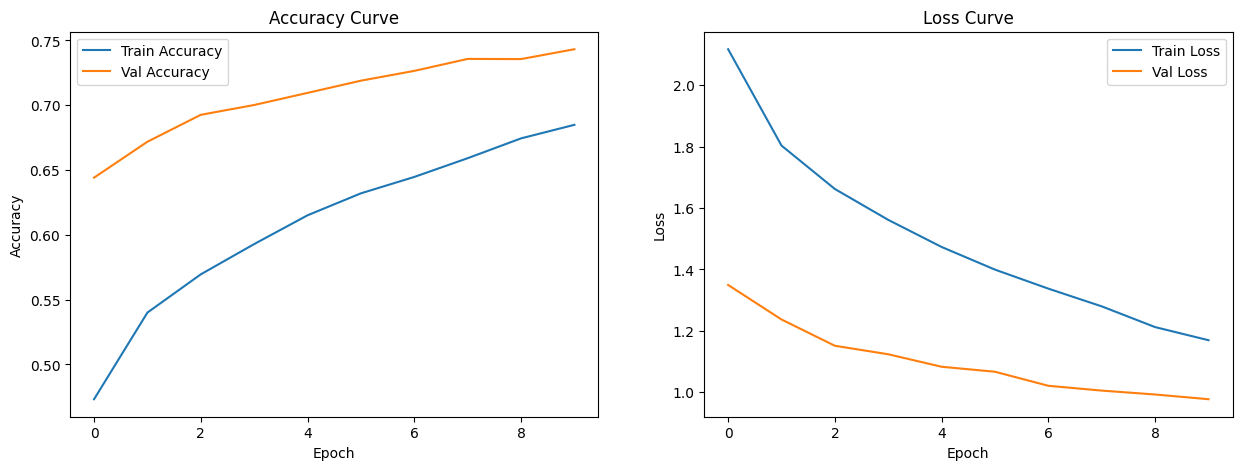

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = "../data/clean/resnet50_training_log.csv"
history = pd.read_csv(log_path)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history["epoch"], history["accuracy"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["epoch"], history["loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

[1] Testing image: ../data/raw/food-101/images/edamame/1530694.jpg


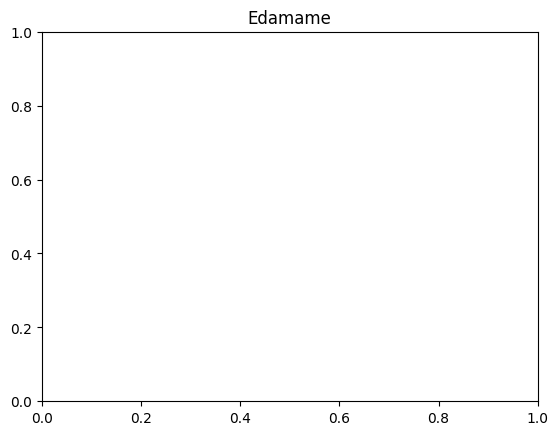

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

--- Predictions ---
1. edamame  (1.0000)
2. seaweed_salad  (0.0000)
3. spring_rolls  (0.0000)
4. churros  (0.0000)
5. gyoza  (0.0000)

--- Nutrition Info ---
description      EDAMAME
calories           106.0
protein             11.8
fat                 4.71
carbohydrates       7.06
Name: 33, dtype: object


[2] Testing image: ../data/raw/food-101/images/cheese_plate/1358652.jpg


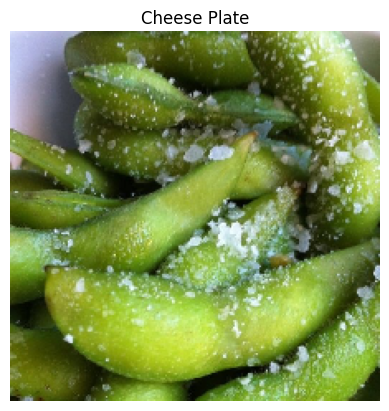

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

--- Predictions ---
1. cheese_plate  (0.3168)
2. donuts  (0.3141)
3. churros  (0.0626)
4. dumplings  (0.0572)
5. hummus  (0.0540)

--- Nutrition Info ---
description      SPANISH CHEESE PLATE
calories                        457.0
protein                          25.0
fat                              35.7
carbohydrates                    3.57
Name: 16, dtype: object


[3] Testing image: ../data/raw/food-101/images/clam_chowder/3129750.jpg


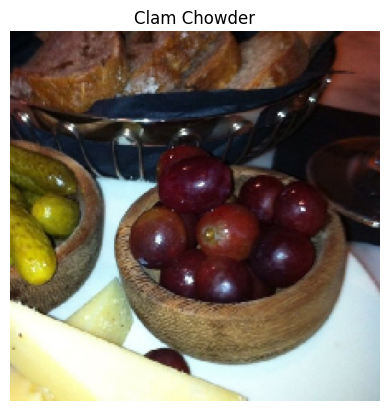

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

--- Predictions ---
1. clam_chowder  (0.7799)
2. lobster_bisque  (0.2193)
3. miso_soup  (0.0006)
4. french_onion_soup  (0.0002)
5. panna_cotta  (0.0000)

--- Nutrition Info ---
description      CLAM CHOWDER
calories                118.0
protein                  3.67
fat                      8.57
carbohydrates            6.53
Name: 24, dtype: object


[4] Testing image: ../data/raw/food-101/images/samosa/730084.jpg


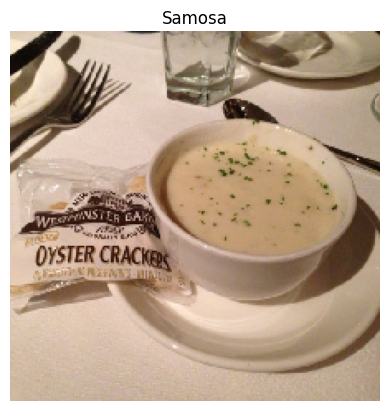

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

--- Predictions ---
1. samosa  (1.0000)
2. spring_rolls  (0.0000)
3. gyoza  (0.0000)
4. breakfast_burrito  (0.0000)
5. fish_and_chips  (0.0000)

--- Nutrition Info ---
description      Samosa
calories          310.0
protein            5.14
fat               17.47
carbohydrates     33.16
Name: 85, dtype: object


[5] Testing image: ../data/raw/food-101/images/huevos_rancheros/1325040.jpg


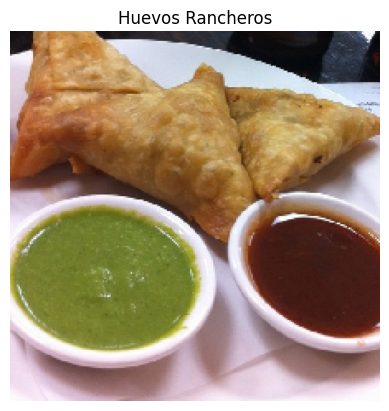

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

--- Predictions ---
1. chicken_curry  (0.1904)
2. hummus  (0.1287)
3. clam_chowder  (0.0887)
4. huevos_rancheros  (0.0825)
5. ramen  (0.0687)

--- Nutrition Info ---
description      Chicken curry
calories                 107.0
protein                   6.48
fat                       6.48
carbohydrates             6.54
Name: 18, dtype: object


[6] Testing image: ../data/raw/food-101/images/prime_rib/190170.jpg


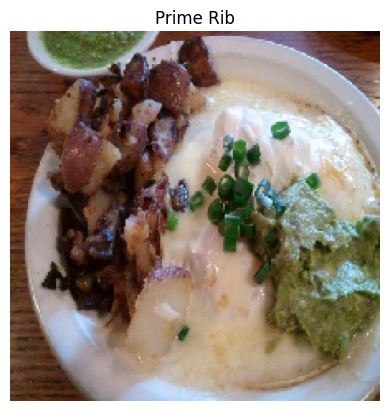

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

--- Predictions ---
1. prime_rib  (0.9958)
2. filet_mignon  (0.0021)
3. steak  (0.0018)
4. pork_chop  (0.0002)
5. foie_gras  (0.0000)

--- Nutrition Info ---
description      SLOW ROASTED BEEF, ROAST BEEF
calories                                 121.0
protein                                   17.2
fat                                       4.31
carbohydrates                             1.72
Name: 79, dtype: object


[7] Testing image: ../data/raw/food-101/images/peking_duck/374396.jpg


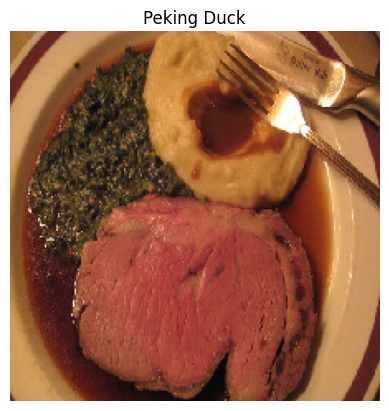

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

--- Predictions ---
1. peking_duck  (0.5394)
2. chicken_wings  (0.0908)
3. samosa  (0.0867)
4. pulled_pork_sandwich  (0.0514)
5. prime_rib  (0.0381)

--- Nutrition Info ---
description      Duck, Peking
calories                154.0
protein                  5.32
fat                     11.76
carbohydrates            6.47
Name: 74, dtype: object


[8] Testing image: ../data/raw/food-101/images/escargots/3860524.jpg


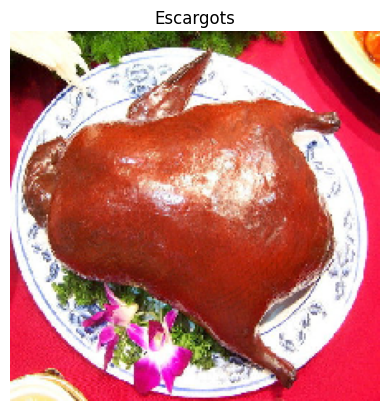

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

--- Predictions ---
1. foie_gras  (0.1844)
2. scallops  (0.1676)
3. filet_mignon  (0.1443)
4. pork_chop  (0.0768)
5. steak  (0.0728)

--- Nutrition Info ---
description      LIVER PATE
calories              267.0
protein                13.3
fat                    21.7
carbohydrates          6.67
Name: 39, dtype: object


[9] Testing image: ../data/raw/food-101/images/miso_soup/2104586.jpg


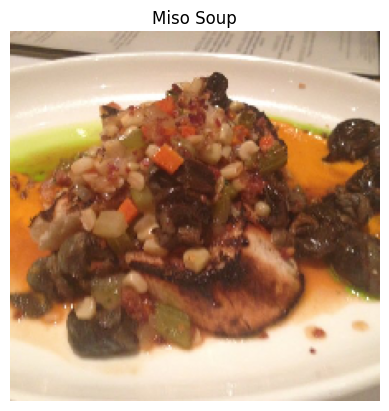

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

--- Predictions ---
1. miso_soup  (0.6090)
2. ramen  (0.2011)
3. hot_and_sour_soup  (0.1231)
4. pho  (0.0298)
5. french_onion_soup  (0.0089)

--- Nutrition Info ---
description      MISO SOUP
calories              26.0
protein               1.92
fat                    0.8
carbohydrates         2.08
Name: 64, dtype: object


[10] Testing image: ../data/raw/food-101/images/carrot_cake/238285.jpg


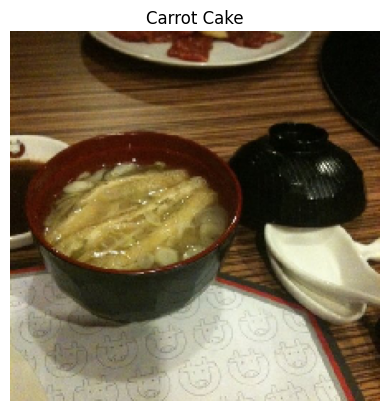

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

--- Predictions ---
1. carrot_cake  (0.9993)
2. chocolate_cake  (0.0004)
3. tiramisu  (0.0002)
4. red_velvet_cake  (0.0000)
5. baklava  (0.0000)

--- Nutrition Info ---
description      CARROT CAKE
calories               519.0
protein                  3.7
fat                     33.3
carbohydrates           59.3
Name: 14, dtype: object




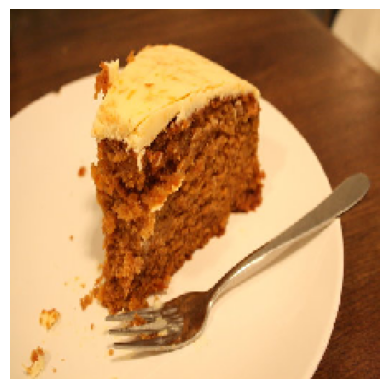

In [8]:
def test_random_images(n=10):

    test_df = pd.read_csv("../data/clean/test_cleaned.csv")

    samples = test_df.sample(n).reset_index(drop=True)

    for i in range(n):
        row = samples.iloc[i]
        img_name = row["image_name"]
        img_path = os.path.join(IMG_DIR, img_name + ".jpg")

        print("="*80)
        print(f"[{i+1}] Testing image: {img_path}")
        print("="*80)

#         # Load and show image
#         img = image.load_img(img_path, target_size=(224, 224))
#         plt.figure(figsize=(4, 4))
#         plt.imshow(img)
#         plt.axis("off")

        # Title = food label from filename
        label_from_path = img_name.split("/")[0].replace("_", " ").title()
        plt.title(label_from_path)
        plt.show()

        # Predict
        predict_image(img_path)
        print("\n")


        
test_random_images(10)